In [3]:
from typing import List, Dict, Tuple, Callable, Union
import os, traceback, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import gc
import traceback
import warnings
from pdb import set_trace
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
weather = None

weather = pd.read_csv('weather_classification_data.csv')

In [5]:
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoded = encoder.fit_transform(weather[['Cloud Cover']])
encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['Cloud Cover']))
weather = pd.concat([weather, encoded], axis=1)
weather = weather.drop(columns=['Cloud Cover'])
encoded = encoder.fit_transform(weather[['Season']])
encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['Season']))
weather = pd.concat([weather, encoded], axis=1)
weather = weather.drop(columns=['Season'])
encoded = encoder.fit_transform(weather[['Location']])
encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['Location']))
weather = pd.concat([weather, encoded], axis=1)
weather = weather.drop(columns=['Location'])

In [7]:
def get_preprocessed_data() -> Tuple[np.ndarray]:
  
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = None, None, None, None, None, None
    # Drop the label column and store the features (pixel values) in X
    X = weather.drop('Weather Type', axis=1).values
    y = weather['Weather Type'].values
    

    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import StandardScaler
    encoder = OneHotEncoder()
    scaler = StandardScaler()

    from sklearn.preprocessing import LabelEncoder, OneHotEncoder


    labels = np.array(['rainy','cloudy','sunny','snowy','rainy'])
    le = LabelEncoder()
    y_int = le.fit_transform(labels)   # [2,1,3,0,2]

    # One-hot encode
    ohe = OneHotEncoder()
    y = ohe.fit_transform(y_int.reshape(-1,1)).toarray()
    
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)
    
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    bias = np.ones((X_trn.shape[0],1))
    X_trn =  np.hstack((bias, X_trn))
    bias = np.ones((X_vld.shape[0],1))
    X_vld =  np.hstack((bias, X_vld))

    bias = np.ones((X_tst.shape[0],1))
    X_tst =  np.hstack((bias, X_tst))


    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [8]:
def get_preprocessed_data() -> Tuple[np.ndarray]:
  
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = None, None, None, None, None, None
    # Drop the label column and store the features (pixel values) in X
    X = weather.drop('Weather Type', axis=1).values
    y = weather['Weather Type'].values
    

    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import StandardScaler
    encoder = OneHotEncoder()
    scaler = StandardScaler()

    y = encoder.fit_transform(y.reshape(-1,1)).toarray()
    
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)
    
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    bias = np.ones((X_trn.shape[0],1))
    X_trn =  np.hstack((bias, X_trn))
    bias = np.ones((X_vld.shape[0],1))
    X_vld =  np.hstack((bias, X_vld))

    bias = np.ones((X_tst.shape[0],1))
    X_tst =  np.hstack((bias, X_tst))


    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [9]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [10]:
class Softmax():
    
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        
        exp_z = np.exp(z - np.max(z))
        return exp_z / exp_z.sum(axis=-1, keepdims=True)
        pass
    
    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        s = np.exp(z - np.max(z)).reshape(-1,1)
        jacobian = np.diagflat(s) - np.dot(s, s.T)
        return jacobian
        pass

In [11]:
class Tanh():
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        
        return np.tanh(z) 
        pass

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        
        return 1 - np.tanh(z)**2
        pass

In [12]:
def init_weights(
    n_input_features: int, 
    hidden_neurons: int, 
    output_neurons: int, 
) -> Tuple[np.ndarray, ...]:
    
    W1, b1, W2, b2 = None, None, None, None
    rng = np.random
    W1 = rng.uniform(low=-0.5, high=0.5, size=(n_input_features, hidden_neurons))
    b1 = np.ones([1, hidden_neurons])
    W2 = rng.uniform(low=-0.5, high=0.5, size=(hidden_neurons, output_neurons))
    b2 = np.ones([1, output_neurons]) 
    return W1, b1, W2, b2

In [13]:
def forward(
    X: np.ndarray, 
    W1: np.ndarray, 
    b1: np.ndarray,
    W2: np.ndarray, 
    b2: np.ndarray, 
) -> Tuple[np.ndarray, ...]:
    Z1, A1, Z2, A2 = None, None, None, None

    Z1 = np.dot(X, W1) + b1
    A1 = Tanh.activation(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = Softmax.activation(Z2) 
    return Z1, A1, Z2, A2

In [14]:
def output_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
   
    W2_avg_grad, b2_avg_grad2 = None, None
    m = y.shape[0]
    dZ2 = A2 - y
    W2_avg_grad = (1/m) * np.dot(A1.T, dZ2)
    b2_avg_grad2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
    return W2_avg_grad, b2_avg_grad2

In [15]:
def hidden_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    
    W1_avg_grad, b1_avg_grad = None, None
    delta_mse_A2 = A2 - y
    delta_A2_Z2 = Softmax.derivative(Z2)
    delta_Z2_A1 = W2
    delta_A1_Z1 = Tanh.derivative(Z1)
    delta_Z1_W1 = X
    delta_mse_W1 = X.T @ ( (delta_mse_A2 @ W2.T) * delta_A1_Z1 )
    W1_avg_grad = delta_mse_W1 / len(y)
    b1_avg_grad = np.sum( (delta_mse_A2 @ W2.T) * delta_A1_Z1 , axis=0, keepdims=True) / len(y)
    
    return W1_avg_grad, b1_avg_grad

In [16]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [17]:
class NeuralNetwork():
    def __init__(self,
        hidden_neurons: int,
        output_neurons: int,
        alpha: float, 
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.batch_size = batch_size
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        self.trn_error = None
        self.vld_error = None

    def fit(
        self,
        X: np.ndarray, 
        y: np.ndarray,
        X_vld: np.ndarray = None, 
        y_vld:np.ndarray = None,
    ): 
        np.random.seed(self.seed)
        self.trn_error = []
        self.vld_error = []
        
        self.W1, self.b1, self.W2, self.b2 = init_weights(
            n_input_features=X.shape[1],
            hidden_neurons=self.hidden_neurons,
            output_neurons=self.output_neurons
        )
        for e in range(self.epochs):
            batches = get_batches(data_len=len(X), batch_size=self.batch_size)
            for b in batches:
                X_batch = X[b]
                y_batch = y[b]
                Z1, A1, Z2, A2 = forward(X_batch, self.W1, self.b1, self.W2, self.b2)
                W2_avg_grad, b2_avg_grad = output_layer_grads(X_batch, y_batch, self.W1, Z1, A1, self.W2, Z2, A2)
                W1_avg_grad, b1_avg_grad = hidden_layer_grads(X_batch, y_batch, self.W1,  Z1, A1, self.W2, Z2, A2)
                self.W2 -= self.alpha * W2_avg_grad
                self.b2 -= self.alpha * b2_avg_grad
                self.W1 -= self.alpha * W1_avg_grad
                self.b1 -= self.alpha * b1_avg_grad
            _, _, _, A2_trn = forward(X, self.W1, self.b1, self.W2, self.b2)
            trn_rmse = rmse(y, A2_trn)
            self.trn_error.append(trn_rmse)
            if X_vld is not None and y_vld is not None:
                _, _, _, A2_vld = forward(X_vld, self.W1, self.b1, self.W2, self.b2)
                vld_rmse = rmse(y_vld, A2_vld)
                self.vld_error.append(vld_rmse)
        return self
    
    def predict(self, X: np.ndarray):
        
        _, _, _, A2 = forward(X, self.W1, self.b1, self.W2, self.b2)
        return A2
        pass

Train MSE: 0.04031138016748184
Train RMSE: 0.19919552199330878
Validation MSE: 0.04005502140981125
Validation RMSE: 0.1994712149235547
Test MSE: 0.04031138016748184
Test RMSE: 0.19919552199330878


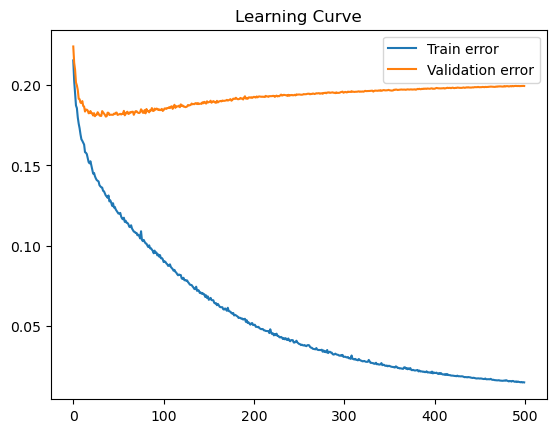

In [18]:

nn = None
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()
nn = NeuralNetwork(
    hidden_neurons=300,
    output_neurons=4,
    batch_size=64,
    alpha=0.05,
    epochs=500,
    seed=0,
    )
nn.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)
y_hat_tst = nn.predict(X_tst)
trn_mse = mse(y_tst, y_hat_tst)
print(f"Train MSE: {trn_mse}")
trn_rmse = rmse(y_tst, y_hat_tst)
print(f"Train RMSE: {trn_rmse}")
vld_mse = mse(y_vld, nn.predict(X_vld))
print(f"Validation MSE: {vld_mse}")
vld_rmse = rmse(y_vld, nn.predict(X_vld))
print(f"Validation RMSE: {vld_rmse}")
tst_mse = mse(y_tst, y_hat_tst)
print(f"Test MSE: {tst_mse}")
tst_rmse = rmse(y_tst, y_hat_tst)
print(f"Test RMSE: {tst_rmse}")

plt.plot(nn.trn_error, label='Train error')
plt.plot(nn.vld_error, label='Validation error')
plt.title("Learning Curve")
plt.legend()
plt.show()


In [20]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None,
    figsize: Tuple = (10, 5)
) -> pd.DataFrame:

    y =  y.flatten() 
    y_hat = y_hat.flatten() 
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    fig, ax = plt.subplots(figsize=figsize)  
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True, fmt='g', ax=ax)
    plt.show()
    return cfm_df

In [21]:
label2name = { 
    0: 'Sunny', 1: 'Cloudy', 2: 'Snowy', 3: 'Rainy'
}

In [22]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

Train Accuracy: 1.0
Validation Accuracy: 0.9029356060606061
Test Accuracy: 0.9037878787878788
Confusion Matrices: Training


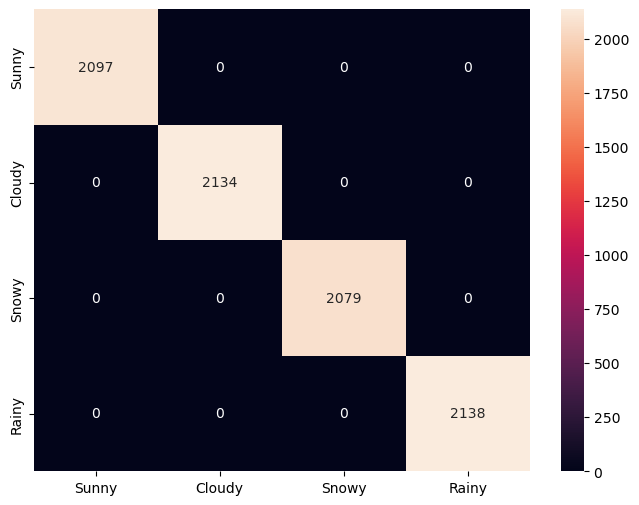

Confusion Matrix: Test


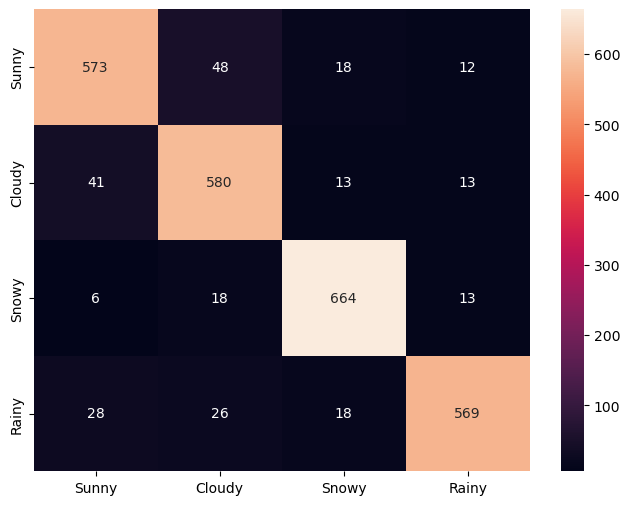

Confusion Matrix: Validation


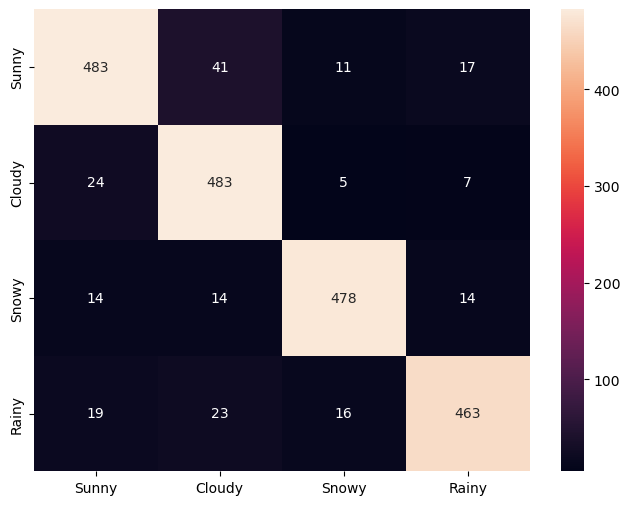

In [24]:
nn = None
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()
nn = NeuralNetwork(
    hidden_neurons=300,
    output_neurons=4,
    batch_size=64,
    alpha=0.05,
    epochs=500,
    seed=0,
    )
nn.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)
y_hat_trn = nn.predict(X_trn)
y_trn_labels = np.argmax(y_trn, axis=1)
y_hat_trn_labels = np.argmax(y_hat_trn, axis=1)
train_accuracy = accuracy_score(y_trn_labels, y_hat_trn_labels)
print(f"Train Accuracy: {train_accuracy}")
y_hat_vld = nn.predict(X_vld)
y_vld_labels = np.argmax(y_vld, axis=1)
y_hat_vld_labels = np.argmax(y_hat_vld, axis=1)
validation_accuracy = accuracy_score(y_vld_labels, y_hat_vld_labels)
print(f"Validation Accuracy: {validation_accuracy}")
y_hat_tst = nn.predict(X_tst)
y_tst_labels = np.argmax(y_tst, axis=1)
y_hat_tst_labels = np.argmax(y_hat_tst, axis=1)
test_accuracy = accuracy_score(y_tst_labels, y_hat_tst_labels)
print(f"Test Accuracy: {test_accuracy}")

print("Confusion Matrices: Training")
cfm_df_trn = plot_confusion_matrix(
    y=np.argmax(y_trn, axis=1), 
    y_hat=np.argmax(nn.predict(X_trn), axis=1), 
    class_names=label2name,
    figsize=(8, 6)
)
print("Confusion Matrix: Test")
cfm_df_tst = plot_confusion_matrix(
    y=y_tst_labels, 
    y_hat=y_hat_tst_labels, 
    class_names=label2name,
    figsize=(8, 6)
)
print("Confusion Matrix: Validation")
cfm_df_vld = plot_confusion_matrix(
    y=np.argmax(y_vld, axis=1), 
    y_hat=np.argmax(nn.predict(X_vld), axis=1), 
    class_names=label2name,
    figsize=(8, 6)
)



